In [26]:
from __future__ import absolute_import, print_function, unicode_literals, division

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf

In [27]:
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers

## Image-Net Transfer Learning Classification / Feature Vector Modules

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

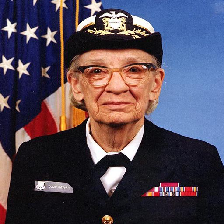

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [25]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [27]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

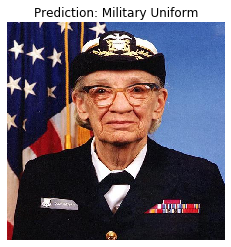

In [31]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [32]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [33]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [40]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [42]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [43]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['bee', 'coral fungus', 'bee', 'greenhouse', 'daisy', 'weevil',
       'daisy', 'pot', 'knot', 'daisy', 'lemon', 'daisy', 'vase',
       'cardoon', 'pot', 'daisy', 'vase', 'daisy', 'rapeseed', 'mushroom',
       'cardoon', 'cardoon', 'tractor', 'daisy', 'sea urchin',
       'sea urchin', 'sea urchin', 'bubble', 'pretzel', 'daisy', 'daisy',
       'daisy'], dtype='<U30')

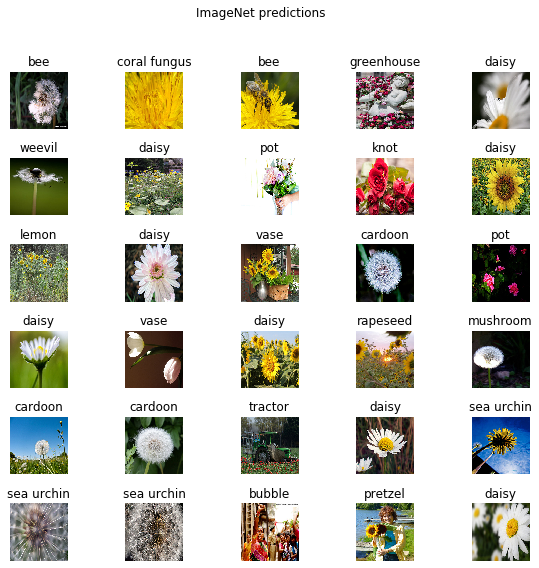

In [45]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [46]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [47]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [48]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [49]:
feature_extractor_layer.trainable = False

In [50]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [52]:
class CollectBatchStats(keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [53]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[batch_stats_callback])

Epoch 1/2
100/115 [=========================>....] - ETA: 47s - loss: 0.6984 - acc: 0.8125

KeyboardInterrupt: 

## Text Embeddings with TF Hub

In [3]:
tf.compat.v1.disable_eager_execution()

In [3]:
tf.compat.v1.enable_eager_execution()

In [4]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [5]:
embeddings = embed(["cat is on the mat", "dog is in the fog"])

In [6]:
embeddings

<tf.Tensor: id=5298, shape=(2, 512), dtype=float32, numpy=
array([[-0.03869507,  0.03391152, -0.00274122, ...,  0.03369762,
         0.01266101, -0.00848943],
       [-0.00839269,  0.05222809,  0.0155375 , ...,  0.02802935,
         0.01753912, -0.01362118]], dtype=float32)>

## Taking a View at a Module

In [4]:
module = hub.Module('https://tfhub.dev/google/imagenet/inception_v3/classification/1')

In [9]:
print('Input info')
module.get_input_info_dict()

Input info


{'images': <hub.ParsedTensorInfo shape=(None, 299, 299, 3) dtype=float32 is_sparse=False>}

In [13]:
print('Output info')
module.get_output_info_dict()

Output info


{'default': <hub.ParsedTensorInfo shape=(None, 1001) dtype=float32 is_sparse=False>}

In [14]:
print('Full info')
module.get_output_info_dict(signature='image_classification')

Full info


{'InceptionV3/Logits': <hub.ParsedTensorInfo shape=(None, 1001) dtype=float32 is_sparse=False>,
 'InceptionV3/Conv2d_2b_3x3': <hub.ParsedTensorInfo shape=(None, 147, 147, 64) dtype=float32 is_sparse=False>,
 'InceptionV3/MaxPool_3a_3x3': <hub.ParsedTensorInfo shape=(None, 73, 73, 64) dtype=float32 is_sparse=False>,
 'InceptionV3/PreLogits': <hub.ParsedTensorInfo shape=(None, 1, 1, 2048) dtype=float32 is_sparse=False>,
 'InceptionV3/Conv2d_3b_1x1': <hub.ParsedTensorInfo shape=(None, 73, 73, 80) dtype=float32 is_sparse=False>,
 'default': <hub.ParsedTensorInfo shape=(None, 1001) dtype=float32 is_sparse=False>,
 'InceptionV3/Mixed_5b': <hub.ParsedTensorInfo shape=(None, 35, 35, 256) dtype=float32 is_sparse=False>,
 'InceptionV3/Mixed_5c': <hub.ParsedTensorInfo shape=(None, 35, 35, 288) dtype=float32 is_sparse=False>,
 'InceptionV3/Mixed_5d': <hub.ParsedTensorInfo shape=(None, 35, 35, 288) dtype=float32 is_sparse=False>,
 'InceptionV3/Mixed_6a': <hub.ParsedTensorInfo shape=(None, 17, 17, 7

In [49]:
hub.get_expected_image_size(module)

[224, 224]